In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist



In [2]:
# Load the dataset
df=pd.read_csv('telcom_data.csv')

In [3]:
df.shape

(150001, 55)

In [4]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311450e+19,04-04-2019 12:01,770.0,25-04-2019 14:35,662.0,1823652.0,2.082010e+14,3.366496e+10,3.552120e+13,9.16457E+15,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311450e+19,09-04-2019 13:04,235.0,25-04-2019 08:15,606.0,1365104.0,2.082020e+14,3.368185e+10,3.579400e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311450e+19,09-04-2019 17:42,1.0,25-04-2019 11:58,652.0,1361762.0,2.082000e+14,3.376063e+10,3.528150e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311450e+19,10-04-2019 00:31,486.0,25-04-2019 07:36,171.0,1321509.0,2.082010e+14,3.375034e+10,3.535660e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311450e+19,12-04-2019 20:10,565.0,25-04-2019 10:40,954.0,1089009.0,2.082010e+14,3.369980e+10,3.540700e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [6]:
def preprocessing(df):
    categorical_cols = []
    continious_cols = []
    for col in df.columns:
        if df[col].dtypes == "object":
            categorical_cols.append(col)
            df[col].fillna(df[col].mode()[0], inplace = True)
            
        else:
            df[col].fillna(df[col].mean(), inplace = True)
            continious_cols.append(col)
    return categorical_cols,continious_cols, df
categorical_cols,continious_cols, df_preprocessed = preprocessing(df)

## Task 4. 1 - Write a Python program to assign:
#### a. Engagement score to each user. Consider the engagement score as the Euclidean distance between the user data point &         the    less engaged cluster (use the first clustering for this) (Euclidean Distance)

#### b. Experience score for each user. Consider the experience score as the Euclidean distance between the user data point &             the worst experience cluster. 


In [7]:
df['Total_Traffic'] = df['Total UL (Bytes)']+df['Total DL (Bytes)']

##### Engagement Metrics



In [8]:
engagement_metrics = df.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'Dur. (ms)': 'sum', 'Total_Traffic': 'sum'})
engagement_metrics.columns = ['Sessions Frequency', 'Session Duration', 'Session Total Traffic']

In [9]:
scaler = MinMaxScaler()
normalized_engagement_metrics = scaler.fit_transform(engagement_metrics)

In [10]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(normalized_engagement_metrics)
engagement_metrics['Cluster'] = kmeans.labels_

In [11]:
## Getting TCP Retransmission

df['TCP Retransmission'] = df['TCP DL Retrans. Vol (Bytes)'] + df['TCP UL Retrans. Vol (Bytes)']
tcp_retransmission = df.groupby('MSISDN/Number')['TCP Retransmission'].mean()
tcp_retransmission

MSISDN/Number
3.360100e+10    2.156957e+07
3.360100e+10    2.156957e+07
3.360100e+10    2.156957e+07
3.360101e+10    7.607247e+05
3.360101e+10    1.547020e+07
                    ...     
3.379000e+10    2.156957e+07
4.188282e+10    1.698397e+07
3.197020e+12    2.156957e+07
3.370000e+14    2.156957e+07
8.823970e+14    2.156957e+07
Name: TCP Retransmission, Length: 106857, dtype: float64

In [12]:
df['RTT'] = (df['Avg RTT DL (ms)'] + df['Avg RTT UL (ms)']) 
rtt = df.groupby('MSISDN/Number')['RTT'].mean()

handset_type = df.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode())

df['Throughput'] = df['Avg Bearer TP DL (kbps)']+df['Avg Bearer TP UL (kbps)']
throughput = df.groupby('MSISDN/Number')['Throughput'].mean()

experience_metrics = pd.concat([tcp_retransmission, rtt, throughput], axis=1)
experience_metrics.columns = ['TCP Retransmission', 'RTT', 'Throughput']

In [13]:
rtt

MSISDN/Number
3.360100e+10     46.000000
3.360100e+10     31.000000
3.360100e+10    127.458589
3.360101e+10     84.000000
3.360101e+10     59.500000
                   ...    
3.379000e+10     40.000000
4.188282e+10    309.123982
3.197020e+12    127.458589
3.370000e+14    127.458589
8.823970e+14    127.458589
Name: RTT, Length: 106857, dtype: float64

In [14]:
experience_metrics

,TCP Retransmission,RTT,Throughput
MSISDN/Number,,,
3.360100e+10,2.156957e+07,46.000000,76.000000
3.360100e+10,2.156957e+07,31.000000,99.000000
3.360100e+10,2.156957e+07,127.458589,97.000000
3.360101e+10,7.607247e+05,84.000000,248.000000
3.360101e+10,1.547020e+07,59.500000,28422.000000
...,...,...,...
3.379000e+10,2.156957e+07,40.000000,116.000000
4.188282e+10,1.698397e+07,309.123982,16958.943222
3.197020e+12,2.156957e+07,127.458589,1.000000


In [15]:
## Process the df for K-Means

def preprocessing(df):
    categorical_cols = []
    continious_cols = []
    for col in df.columns:
        if df[col].dtypes == "object":
            categorical_cols.append(col)
            df[col].fillna(df[col].mode()[0], inplace = True)
            
        else:
            df[col].fillna(df[col].mean(), inplace = True)
            continious_cols.append(col)
    return categorical_cols,continious_cols, df

categorical_cols,continious_cols, df_preprocessed = preprocessing(df)

In [16]:
scaler = MinMaxScaler()
normalized_experience_metrics = scaler.fit_transform(experience_metrics)

In [17]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(normalized_experience_metrics)
experience_metrics['Cluster'] = kmeans.labels_

In [18]:
less_engaged_cluster_center = kmeans.cluster_centers_[np.argmin(kmeans.cluster_centers_[:, 0])]
engagement_score = cdist(normalized_engagement_metrics, [less_engaged_cluster_center], metric='euclidean').flatten()

# Assign an experience score for each user. Consider the experience score as the Euclidean distance between the user data point & the worst experience cluster.
worst_experience_cluster_center = kmeans.cluster_centers_[np.argmax(kmeans.cluster_centers_[:, 0])]
experience_score = cdist(normalized_experience_metrics, [worst_experience_cluster_center], metric='euclidean').flatten()

In [19]:
less_engaged_cluster_center

array([0.00410257, 0.0014816 , 0.0077924 ])

In [20]:
engagement_score

array([0.00743647, 0.00865023, 0.00789035, ..., 0.01350622, 0.00811239,
       0.01352285])

In [21]:
worst_experience_cluster_center

array([0.01758266, 0.00098064, 0.29539768])

In [22]:
experience_score

array([0.29539793, 0.29531731, 0.2953238 , ..., 0.2956616 , 0.295549  ,
       0.29565808])

In [23]:
engagement_metrics['engagement_score'] = engagement_score
engagement_metrics['experience_score'] = experience_score

In [24]:
engagement_metrics

,Sessions Frequency,Session Duration,Session Total Traffic,Cluster,engagement_score,experience_score
MSISDN/Number,,,,,,
3.360100e+10,1,1.167200e+05,8.786906e+08,0,0.007436,0.295398
3.360100e+10,1,1.812300e+05,1.568596e+08,0,0.008650,0.295317
3.360100e+10,1,1.349690e+05,5.959665e+08,0,0.007890,0.295324
3.360101e+10,1,4.987800e+04,4.223207e+08,0,0.008215,0.295038
3.360101e+10,2,3.710400e+04,1.457411e+09,0,0.006108,0.195796
...,...,...,...,...,...,...
3.379000e+10,1,1.409880e+05,4.803073e+08,0,0.008080,0.295257
4.188282e+10,1066,7.255100e+07,5.317447e+11,1,1.724334,0.236073
3.197020e+12,1,8.773850e+05,2.321240e+08,2,0.013506,0.295662


####  Task 4.2   Consider the average of both engagement & experience scores as  the satisfaction score & report the top 10         satisfied customer 


In [25]:
engagement_metrics['satisfaction_score'] = (engagement_metrics['engagement_score'] + engagement_metrics['experience_score'])/2

In [26]:
engagement_metrics

,Sessions Frequency,Session Duration,Session Total Traffic,Cluster,engagement_score,experience_score,satisfaction_score
MSISDN/Number,,,,,,,
3.360100e+10,1,1.167200e+05,8.786906e+08,0,0.007436,0.295398,0.151417
3.360100e+10,1,1.812300e+05,1.568596e+08,0,0.008650,0.295317,0.151984
3.360100e+10,1,1.349690e+05,5.959665e+08,0,0.007890,0.295324,0.151607
3.360101e+10,1,4.987800e+04,4.223207e+08,0,0.008215,0.295038,0.151626
3.360101e+10,2,3.710400e+04,1.457411e+09,0,0.006108,0.195796,0.100952
...,...,...,...,...,...,...,...
3.379000e+10,1,1.409880e+05,4.803073e+08,0,0.008080,0.295257,0.151669
4.188282e+10,1066,7.255100e+07,5.317447e+11,1,1.724334,0.236073,0.980203
3.197020e+12,1,8.773850e+05,2.321240e+08,2,0.013506,0.295662,0.154584


In [27]:
## Top 10 satisfied Customers

engagement_metrics['satisfaction_score'].nlargest(10)

MSISDN/Number
4.188282e+10    0.980203
3.366232e+10    0.525171
3.369858e+10    0.503843
3.365871e+10    0.494004
3.366491e+10    0.493936
3.365863e+10    0.493046
3.366613e+10    0.486311
3.366877e+10    0.480326
3.366131e+10    0.477756
3.366240e+10    0.474833
Name: satisfaction_score, dtype: float64

In [28]:
engagement_metrics

,Sessions Frequency,Session Duration,Session Total Traffic,Cluster,engagement_score,experience_score,satisfaction_score
MSISDN/Number,,,,,,,
3.360100e+10,1,1.167200e+05,8.786906e+08,0,0.007436,0.295398,0.151417
3.360100e+10,1,1.812300e+05,1.568596e+08,0,0.008650,0.295317,0.151984
3.360100e+10,1,1.349690e+05,5.959665e+08,0,0.007890,0.295324,0.151607
3.360101e+10,1,4.987800e+04,4.223207e+08,0,0.008215,0.295038,0.151626
3.360101e+10,2,3.710400e+04,1.457411e+09,0,0.006108,0.195796,0.100952
...,...,...,...,...,...,...,...
3.379000e+10,1,1.409880e+05,4.803073e+08,0,0.008080,0.295257,0.151669
4.188282e+10,1066,7.255100e+07,5.317447e+11,1,1.724334,0.236073,0.980203
3.197020e+12,1,8.773850e+05,2.321240e+08,2,0.013506,0.295662,0.154584


##### Task 4.3  Build a regression model of your choice to predict the satisfaction score of a customer. 


In [29]:
## Regression Model  --> Linear Regression Model

# Define X and y
X,y =  engagement_metrics.drop(["satisfaction_score"], axis =1 ), engagement_metrics["satisfaction_score"]

In [30]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((85485, 6), (21372, 6), (85485,), (21372,))

In [32]:
# Modelling
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Starting training
model.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_pred

array([0.10863294, 0.151691  , 0.08904796, ..., 0.15157799, 0.15079756,
       0.1510654 ])

In [35]:
from sklearn.metrics import r2_score

In [36]:
r2_score(y_test, y_pred)

1.0

In [37]:
y_pred_train = model.predict(X_train)

In [38]:
y_pred_train


array([0.11048174, 0.12165254, 0.08053288, ..., 0.06108847, 0.26835277,
       0.01854088])

In [39]:
r2_score(y_train, y_pred_train)

1.0

In [40]:
import matplotlib.pyplot as plt

In [41]:
index = []
for i in range(len(X_test)):
    index.append(i)

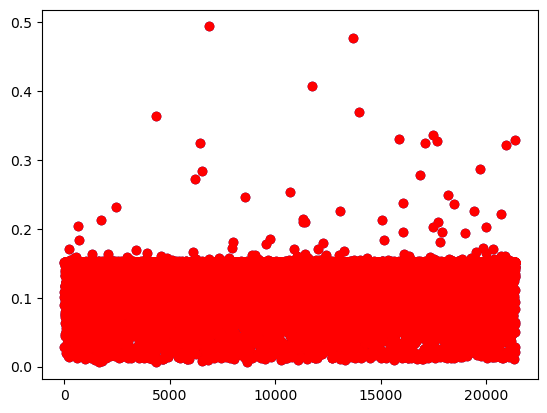

In [42]:
plt.scatter( index,y_test, color =  "darkblue")
plt.scatter( index,y_pred, color =  "red")

##### Task 4.4   Run a k-means (k=2) on the engagement & the experience score. 


In [43]:
cluster_data = engagement_metrics.iloc[:,4:6]
cluster_data

,engagement_score,experience_score
MSISDN/Number,,
3.360100e+10,0.007436,0.295398
3.360100e+10,0.008650,0.295317
3.360100e+10,0.007890,0.295324
3.360101e+10,0.008215,0.295038
3.360101e+10,0.006108,0.195796
...,...,...
3.379000e+10,0.008080,0.295257
4.188282e+10,1.724334,0.236073
3.197020e+12,0.013506,0.295662


In [44]:
km = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
label = km.fit_predict(cluster_data)
centroids = km.cluster_centers_
print(f'# Centroids of the clustering:\n{centroids}')
print(f'# The number of iterations required to converge: {km.inertia_}')
print(f'# The number of iterations required to converge: {km.n_iter_}')

# Centroids of the clustering:
[[0.00761779 0.1348534 ]
 [0.00792768 0.28450955]]
# The number of iterations required to converge: 128.51327258368534
# The number of iterations required to converge: 9


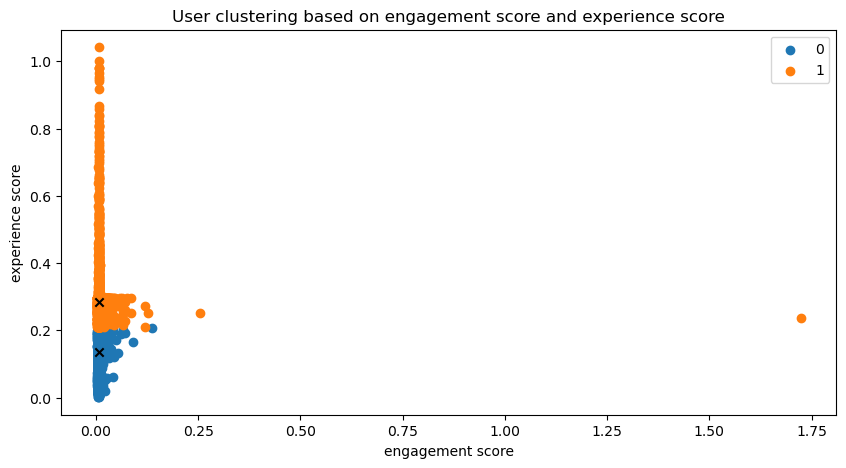

In [45]:
u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize=(10,5))
plt.title(f'User clustering based on engagement score and experience score')
for i in u_labels:
    plt.scatter(cluster_data[label == i].iloc[:,0] , cluster_data[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1], marker='x', color = 'black')
plt.xlabel("engagement score")
plt.ylabel("experience score")
plt.legend()
plt.savefig('kmeans.png')
plt.show()


##### Task 4.5  Aggregate the average satisfaction & experience score per cluster. 

In [46]:
Aggregate_data = engagement_metrics.copy(deep=True)
Aggregate_data['cluster'] = label
Aggregate_data

,Sessions Frequency,Session Duration,Session Total Traffic,Cluster,engagement_score,experience_score,satisfaction_score,cluster
MSISDN/Number,,,,,,,,
3.360100e+10,1,1.167200e+05,8.786906e+08,0,0.007436,0.295398,0.151417,1
3.360100e+10,1,1.812300e+05,1.568596e+08,0,0.008650,0.295317,0.151984,1
3.360100e+10,1,1.349690e+05,5.959665e+08,0,0.007890,0.295324,0.151607,1
3.360101e+10,1,4.987800e+04,4.223207e+08,0,0.008215,0.295038,0.151626,1
3.360101e+10,2,3.710400e+04,1.457411e+09,0,0.006108,0.195796,0.100952,0
...,...,...,...,...,...,...,...,...
3.379000e+10,1,1.409880e+05,4.803073e+08,0,0.008080,0.295257,0.151669,1
4.188282e+10,1066,7.255100e+07,5.317447e+11,1,1.724334,0.236073,0.980203,1
3.197020e+12,1,8.773850e+05,2.321240e+08,2,0.013506,0.295662,0.154584,1


In [47]:
Aggregate_columns = {'engagement_score':'mean','experience_score':'mean','satisfaction_score':'mean'}
#Group and Aggregate
Aggregate_data =Aggregate_data.groupby('cluster').agg(Aggregate_columns)

In [48]:
Aggregate_data

,engagement_score,experience_score,satisfaction_score
cluster,,,
0,0.007618,0.134767,0.071192
1,0.007928,0.284488,0.146208


##### Task 4.6  Export your final table containing all user id + engagement, experience & satisfaction scores in your local MySQL database. Report a screenshot of a select query output on the exported table. 

In [49]:
Final_Table = engagement_metrics.copy(deep=True)
Final_Table.reset_index(inplace=True)
Final_Table = Final_Table.rename(columns={'MSISDN/Number': 'user_id'})

In [50]:

Final_Table

,user_id,Sessions Frequency,Session Duration,Session Total Traffic,Cluster,engagement_score,experience_score,satisfaction_score
0,3.360100e+10,1,1.167200e+05,8.786906e+08,0,0.007436,0.295398,0.151417
1,3.360100e+10,1,1.812300e+05,1.568596e+08,0,0.008650,0.295317,0.151984
2,3.360100e+10,1,1.349690e+05,5.959665e+08,0,0.007890,0.295324,0.151607
3,3.360101e+10,1,4.987800e+04,4.223207e+08,0,0.008215,0.295038,0.151626
4,3.360101e+10,2,3.710400e+04,1.457411e+09,0,0.006108,0.195796,0.100952
...,...,...,...,...,...,...,...,...
106852,3.379000e+10,1,1.409880e+05,4.803073e+08,0,0.008080,0.295257,0.151669
106853,4.188282e+10,1066,7.255100e+07,5.317447e+11,1,1.724334,0.236073,0.980203
106854,3.197020e+12,1,8.773850e+05,2.321240e+08,2,0.013506,0.295662,0.154584
106855,3.370000e+14,1,2.530300e+05,5.962878e+08,0,0.008112,0.295549,0.151831


In [51]:
Final_Table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106857 entries, 0 to 106856
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                106857 non-null  float64
 1   Sessions Frequency     106857 non-null  int64  
 2   Session Duration       106857 non-null  float64
 3   Session Total Traffic  106857 non-null  float64
 4   Cluster                106857 non-null  int32  
 5   engagement_score       106857 non-null  float64
 6   experience_score       106857 non-null  float64
 7   satisfaction_score     106857 non-null  float64
dtypes: float64(6), int32(1), int64(1)
memory usage: 6.1 MB


In [52]:
Final_Table.columns


Index(['user_id', 'Sessions Frequency', 'Session Duration',
       'Session Total Traffic', 'Cluster', 'engagement_score',
       'experience_score', 'satisfaction_score'],
      dtype='object')

In [53]:
Final_table = Final_Table.drop(['Sessions Frequency','Session Duration','Session Total Traffic','Cluster' ],axis=1)

In [54]:
Final_table

,user_id,engagement_score,experience_score,satisfaction_score
0,3.360100e+10,0.007436,0.295398,0.151417
1,3.360100e+10,0.008650,0.295317,0.151984
2,3.360100e+10,0.007890,0.295324,0.151607
3,3.360101e+10,0.008215,0.295038,0.151626
4,3.360101e+10,0.006108,0.195796,0.100952
...,...,...,...,...
106852,3.379000e+10,0.008080,0.295257,0.151669
106853,4.188282e+10,1.724334,0.236073,0.980203
106854,3.197020e+12,0.013506,0.295662,0.154584
106855,3.370000e+14,0.008112,0.295549,0.151831


In [55]:
 # Establish a connection to the SQL Server database 
import pyodbc
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SHYAM;'
                      'Database=TelcoProject;'
                      'Trusted_Coneection=yes;')

In [56]:
# SQL query to fetch data from a table
cursor1= conn.cursor()
cursor1.execute('SELECT * FROM users_experiance')
for row in cursor1:
    print(row)

(33601000000.0, 0.007435, 0.295398, 0.151416)
(33601000000.0, 0.008648, 0.295317, 0.151983)
(33601000000.0, 0.007889, 0.295324, 0.151606)
(33601010000.0, 0.008213, 0.295038, 0.151625)
(33601010000.0, 0.006106, 0.195796, 0.100951)
(33601010000.0, 0.007651, 0.281871, 0.144761)
(33601010000.0, 0.007341, 0.221048, 0.114194)
(33601010000.0, 0.00832, 0.291526, 0.149923)
(33601010000.0, 0.008573, 0.295333, 0.151953)
(33601020000.0, 0.007667, 0.295159, 0.151413)


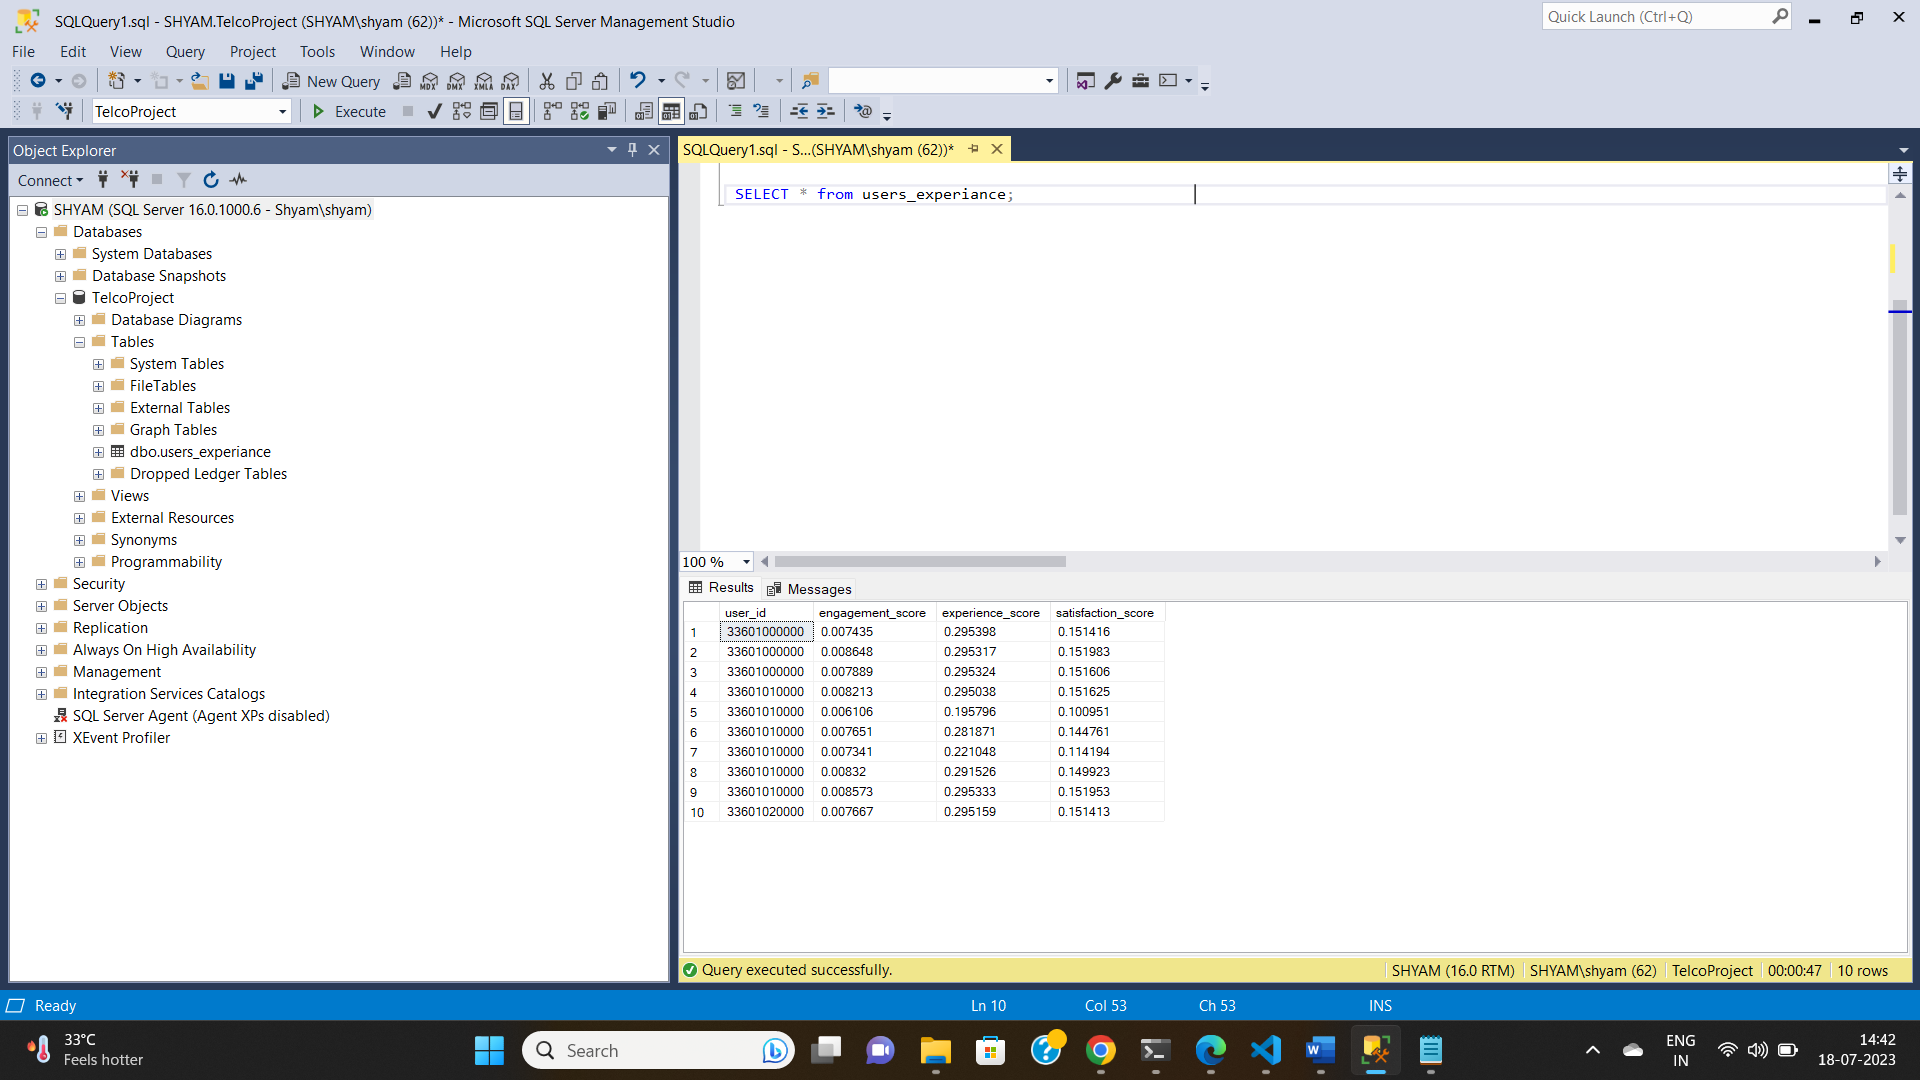

In [58]:
import pickle
pickle.dump(Final_table,open('model.sav','wb'))